# Etivity 1

## Student Name: Garret Molloy
## Student ID: 9021906

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import math
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

# Task 1

## 1.1 Load bank-et1.csv into a Pandas dataframe

In [3]:
df = pd.read_csv('bank_et1.csv')

## 1.2 Examine the first few data rows and the last few data rows. 

In [4]:
# Print first 5 rows of the dataframe
df.head(5)

,Unnamed: 0,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,0,32,technician,single,tertiary,no,392,1.300134,0.473895,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,1,39,technician,divorced,secondary,no,688,-0.193701,0.237021,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,2,59,retired,married,secondary,no,1035,1.334266,0.121981,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,3,47,blue-collar,married,secondary,no,398,0.362286,1.251328,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,4,54,retired,married,secondary,no,1004,0.072075,-0.533738,yes,no,cellular,1,apr,479,1,307,1,failure,no


In [5]:
# Print last 5 rows of the dataframe
df.tail(5)

,Unnamed: 0,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
1995,1995,20,student,single,NaN,no,2785,-2.170524,1.081071,no,no,cellular,16,sep,327,2,-1,0,NaN,yes
1996,1996,28,admin.,single,secondary,no,127,0.811788,1.134496,no,no,cellular,16,sep,1334,2,-1,0,NaN,yes
1997,1997,81,retired,married,primary,no,1154,0.504655,0.042190,no,no,telephone,17,sep,231,1,-1,0,NaN,yes
1998,1998,46,services,married,primary,no,4343,-0.965874,0.302708,yes,no,NaN,20,sep,185,1,-1,0,NaN,yes
1999,1999,40,entrepreneur,married,secondary,no,6403,-0.800893,1.066659,no,no,cellular,22,sep,208,2,-1,0,NaN,yes


## 1.3 Identify an attribute that can be the target/dependable variable for 2-class classification.
Follow the examples in the provided notebook “Lab 1 - Exploratory Data Analysis. ipynb ” (see section Material, Resources and Online Meetings below).

In [6]:
# Drop Unamed Column as it is just an ID 
del df['Unnamed: 0']

# Print statistical summary for all numerical attributes
df.describe()

,age,balance,ratio_bal_ln,ratio_ln_inc,day,duration,campaign,pdays,previous
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,41.751500,1413.663500,0.241951,0.485030,13.851500,292.020500,1.909500,167.896000,2.561500
std,12.723077,3131.224213,0.821604,1.075543,9.712189,221.557295,1.378862,131.754126,3.400735
min,18.000000,-980.000000,-2.632068,-2.851405,1.000000,7.000000,1.000000,-1.000000,0.000000
25%,32.000000,201.500000,-0.308018,-0.274181,5.000000,146.000000,1.000000,75.750000,1.000000
50%,38.000000,551.000000,0.224099,0.487082,12.000000,236.000000,1.000000,182.000000,2.000000
75%,50.000000,1644.500000,0.806315,1.211896,23.000000,379.000000,2.000000,251.000000,3.000000
max,93.000000,81204.000000,2.961979,4.046914,31.000000,1823.000000,11.000000,854.000000,55.000000


In [7]:
df.count()

age             2000
job             1990
marital         2000
education       1896
default         2000
balance         2000
ratio_bal_ln    2000
ratio_ln_inc    2000
housing         2000
loan            2000
contact         1809
day             2000
month           2000
duration        2000
campaign        2000
pdays           2000
previous        2000
poutcome        1546
subscribed      2000
dtype: int64

So we have 2000 records. But some features have missing or blank entries.

In [8]:
df['default'].value_counts()

no     1985
yes      15
Name: default, dtype: int64

In [9]:
df['job'].value_counts()

management       461
technician       348
blue-collar      298
admin.           247
services         165
retired          162
student           96
unemployed        69
self-employed     64
entrepreneur      45
housemaid         35
Name: job, dtype: int64

In [10]:
df['loan'].value_counts()

no     1750
yes     250
Name: loan, dtype: int64

In [11]:
df['housing'].value_counts()

no     1037
yes     963
Name: housing, dtype: int64

## Ans 1.3: Identify Target

If __'default'__ means that this customer of the bank has defaulted on a loan, this could be a valuable 2-class classificaiton that can be the target variable with values ('yes'/'no').

Other candidates may be:
__'subscribed'__  also a 2-class classifier ('yes'/'no') - presuming subscribed is something interesting for the bank and something we want them to do.

After EDA below, I found that there was too few records with default 152000, with this low populaiton we would not have enough informaiotn to make a robust decision. 
Based on this I will choose __subscribed__
subscribed has a 50-50 distribution amongst the records, 1000 of each so we have plenty of data for both outcomes to train and test on.

# Task 2 - EDA

## 2.1 Calculate statistics for numerical and categorical attributes

In [12]:
# Print statistical summary for all numerical attributes
df.describe()

,age,balance,ratio_bal_ln,ratio_ln_inc,day,duration,campaign,pdays,previous
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,41.751500,1413.663500,0.241951,0.485030,13.851500,292.020500,1.909500,167.896000,2.561500
std,12.723077,3131.224213,0.821604,1.075543,9.712189,221.557295,1.378862,131.754126,3.400735
min,18.000000,-980.000000,-2.632068,-2.851405,1.000000,7.000000,1.000000,-1.000000,0.000000
25%,32.000000,201.500000,-0.308018,-0.274181,5.000000,146.000000,1.000000,75.750000,1.000000
50%,38.000000,551.000000,0.224099,0.487082,12.000000,236.000000,1.000000,182.000000,2.000000
75%,50.000000,1644.500000,0.806315,1.211896,23.000000,379.000000,2.000000,251.000000,3.000000
max,93.000000,81204.000000,2.961979,4.046914,31.000000,1823.000000,11.000000,854.000000,55.000000


In [13]:
# Print statistics for all categorical attributes
df['job'].value_counts()

management       461
technician       348
blue-collar      298
admin.           247
services         165
retired          162
student           96
unemployed        69
self-employed     64
entrepreneur      45
housemaid         35
Name: job, dtype: int64

In [14]:
# PRint the statistics for the Categorical Values
def attribute_stats(list):
    for x in list:
        records = df[x].count()
        blank_records = 2000 - records
        print("\n ==== " + x + " - " + str(records) + " records (" + str(blank_records) + " blank) ====")
        print(df[x].value_counts(normalize=True, dropna=False))
    
attribute_stats(["job","marital", "education", "default", "housing", "loan", "contact", "poutcome", "subscribed"])


 ==== job - 1990 records (10 blank) ====
management       0.2305
technician       0.1740
blue-collar      0.1490
admin.           0.1235
services         0.0825
retired          0.0810
student          0.0480
unemployed       0.0345
self-employed    0.0320
entrepreneur     0.0225
housemaid        0.0175
NaN              0.0050
Name: job, dtype: float64

 ==== marital - 2000 records (0 blank) ====
married     0.5555
single      0.3370
divorced    0.1075
Name: marital, dtype: float64

 ==== education - 1896 records (104 blank) ====
secondary    0.4975
tertiary     0.3420
primary      0.1085
NaN          0.0520
Name: education, dtype: float64

 ==== default - 2000 records (0 blank) ====
no     0.9925
yes    0.0075
Name: default, dtype: float64

 ==== housing - 2000 records (0 blank) ====
no     0.5185
yes    0.4815
Name: housing, dtype: float64

 ==== loan - 2000 records (0 blank) ====
no     0.875
yes    0.125
Name: loan, dtype: float64

 ==== contact - 1809 records (191 blank) ====
cel

## 2.2 Plot the distribution of two numerical and two categorical attributes. Draw short conclusions 

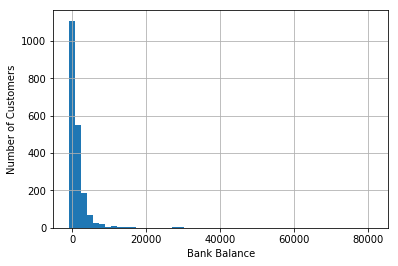

In [15]:
# Let's start by plotting a histogram of ApplicantIncome using the command:

# Numberical 1 Plot - Balance
df['balance'].hist(bins=50)
plt.xlabel('Bank Balance')
plt.ylabel('Number of Customers')
plt.show()

Seems the plot goes out to 80000 but we have negligible number of customers in this range, may be outliers.
A Box plot may identify these better.

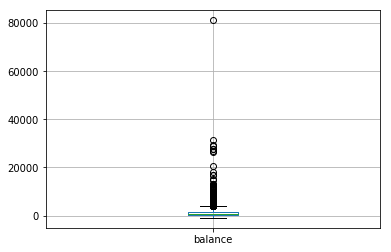

In [16]:
df.boxplot(column='balance')
plt.show()

Balance: Indeed there is a single outlier at 80,000 balance.
If I remove that outlier what will I get?


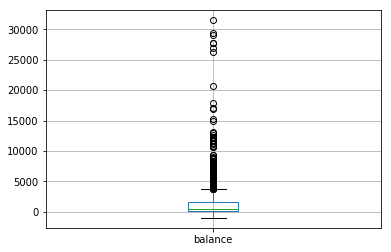

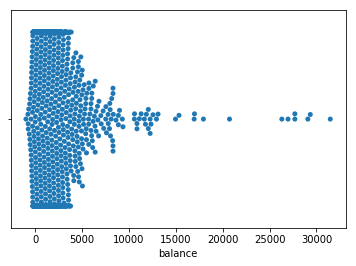

count     1999.000000
mean      1373.748374
std       2573.216453
min       -980.000000
25%        201.000000
50%        550.000000
75%       1642.000000
max      31472.000000
Name: balance, dtype: float64

In [20]:
df2 = df[df["balance"] < 60000]

df2.boxplot(column="balance")
plt.show()

sns.swarmplot(x=df2['balance'])
plt.show()

df2['balance'].describe()

# Usual boxplot
#sns.boxplot(x='balance', y='subscribed', data=df2)
 
# Add jitter with the swarmplot function.
#ax = sns.swarmplot(x='balance', y='subscribed', data=df, color="grey")
#ax.show()

Need to see a distribution to help understand volumes.

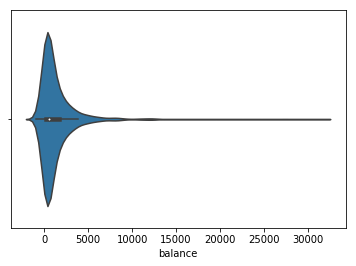

In [21]:
sns.violinplot(x=df2["balance"])

Now we can see the majority of the blances are under 3k

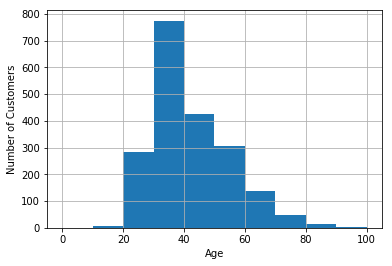

In [22]:
# Numerical 2 plot - Age
df['age'].hist(range=(0,100),bins=10)
plt.xlabel('Age')
plt.ylabel('Number of Customers')
plt.show()

Age: Mostly over 20, under 80. Biggest group 30-40

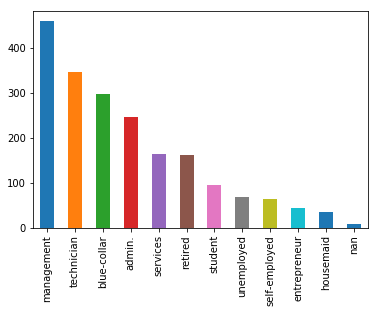

In [23]:
# Plot Category 1 - Job
df['job'].value_counts(dropna=False).plot(kind='bar')
plt.show()

Management is this most popular job, them technocan then blue-collar. I added "nan" which is blanks, there aare only a few blanks. We could remove these from our training for example.

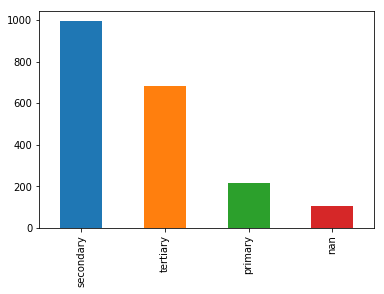

In [24]:
# Plot Category 2 - Education
df['education'].value_counts(dropna=False).plot(kind='bar')
plt.show()

I added "nan" which is blank entries, there are a few. We could remove these or focus on Secondary, Teiary and Other for example.
We have many with Secondary and Tetriary.

## 2.3 Generate two plots with the combined distribution of attributes and draw conclusions from them

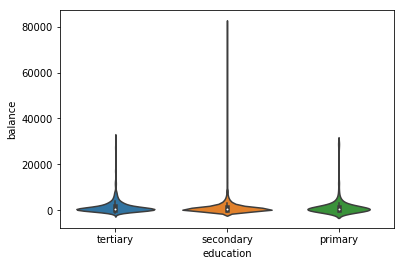

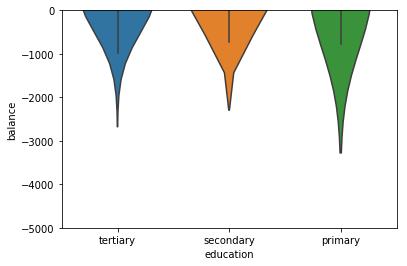

In [25]:
# Combined attributes 1 - Education & balance
sns.violinplot(x='education', y='balance', data=df, fit_reg=False) 
plt.show()
sns.violinplot(x='education', y='balance', data=df, fit_reg=False) 
plt.ylim(-5000, 0)
plt.show()

Primary has large number of +ive < 1000 balances. Tertiary is spread to 2000.
Primry has a large number of negative balances.
When I look at the actual values - I see only 10 values below -500 for all, and the lowest is -980, so I do not se the violin plot being accurate.

In [26]:
df[df['balance']<-500].describe()

,age,balance,ratio_bal_ln,ratio_ln_inc,day,duration,campaign,pdays,previous
count,10.000000,10.000000,10.000000,10.000000,10.00000,10.000000,10.000000,10.000000,10.000000
mean,43.900000,-672.100000,0.606062,0.062588,15.40000,197.500000,2.100000,137.500000,0.900000
std,8.006248,140.350712,0.730185,0.990056,11.88089,121.169532,1.197219,121.969258,0.875595
min,33.000000,-980.000000,-0.484309,-1.660590,2.00000,52.000000,1.000000,-1.000000,0.000000
25%,39.000000,-741.750000,0.104316,-0.379823,8.00000,122.250000,1.250000,-1.000000,0.000000
50%,42.500000,-646.500000,0.659399,0.044637,8.00000,183.000000,2.000000,185.500000,1.000000
75%,47.500000,-563.000000,1.021992,0.984313,28.75000,215.000000,2.000000,247.750000,1.750000
max,57.000000,-528.000000,1.867728,1.125650,30.00000,484.000000,5.000000,260.000000,2.000000


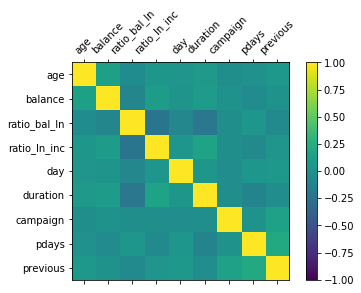

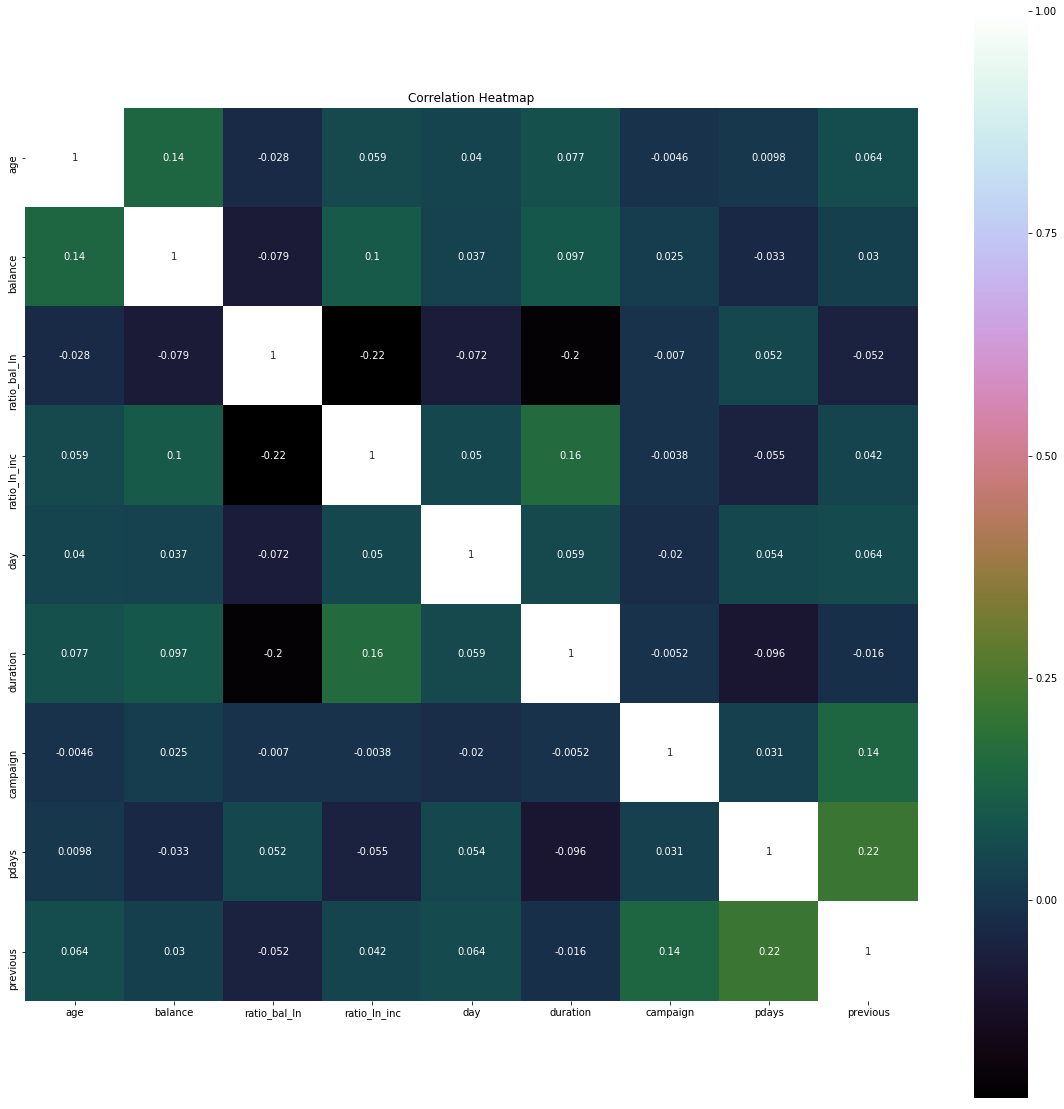

In [27]:
import numpy as np
names=["age","balance","ratio_bal_ln", "ratio_ln_inc", "day","duration","campaign","pdays","previous"]
df3 = df[names]
         
# Plot the correlation matrix for numerical values
correlations = df3.corr()
# plot correlation matrix
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,9,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(names, rotation=45)
ax.set_yticklabels(names)
correlations.style.background_gradient().set_precision(2)
plt.show()
plt.figure(figsize=(20, 20))  
plt.title("Correlation Heatmap")
sns.heatmap(correlations, vmax=1, square=True, annot=True, cmap='cubehelix')

No very strong correlations

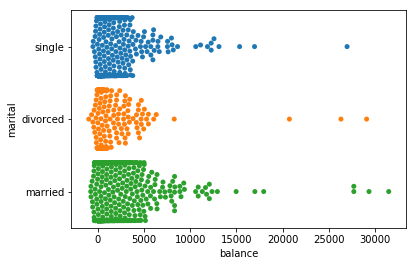

In [28]:
# Combined attributes 1 - Marital & balance
sns.swarmplot(x=df2['balance'], y=df["marital"])

In [29]:
df['marital'].value_counts()

married     1111
single       674
divorced     215
Name: marital, dtype: int64

Divorced seem to have less of a balance at the higer end (above 5000)

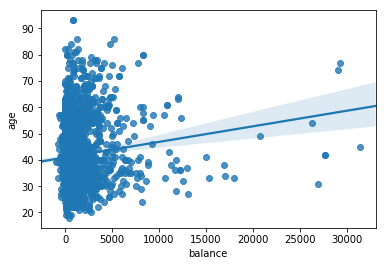

In [30]:
# plot Age V Balance
sns.regplot(y='age', x='balance', data=df2)

Pretty uniform above and bleow the age line. Not seeing a correlation. 

## 2.4 Generate additional plots to identify two numerical attributes that can potentially be used for predicting the value of the dependent variable you chose in Task 1

Text(0.5,0.98,'')

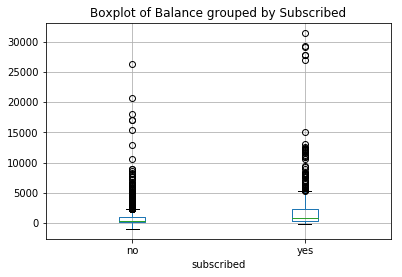

In [31]:
# Plot Predict 1 - Balance & Subscribed
# Boxplots of balance, grouped by the categorical attribute Education
df2.boxplot(column='balance', by='subscribed')
plt.title('Boxplot of Balance grouped by Subscribed')
plt.suptitle("") 

Clearly there is a relationship. I'd like a scatter plot or violin plot to show volumes better.

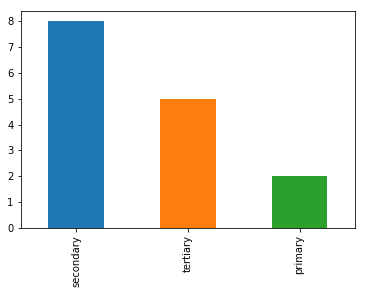

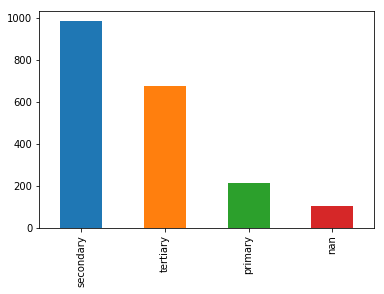

In [32]:
df_default_yes=df[df['default']=='yes']
df_default_no=df[df['default']=='no']

df_default_yes['education'].value_counts(dropna=False).plot(kind='bar')
plt.show()

df_default_no['education'].value_counts(dropna=False).plot(kind='bar')
plt.show()



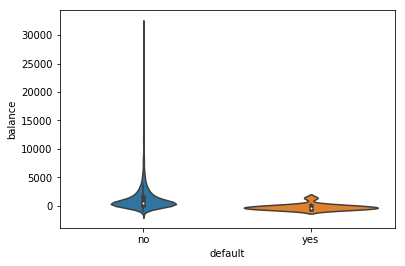

In [33]:
sns.violinplot(x='default', y='balance', data=df2) 
plt.show()

In [34]:
df['default'].value_counts()

no     1985
yes      15
Name: default, dtype: int64

Balance seems to be a clear indicator of default. We only have 15 defaults, so it is a very low population, but all balances are low for these.


After changing y target to __'subscribed'__ I will redo these comparisons to 'subscribed' instead

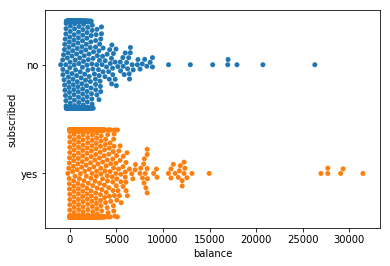

In [35]:
sns.swarmplot(x=df2['balance'], y=df2["subscribed"])
plt.show()

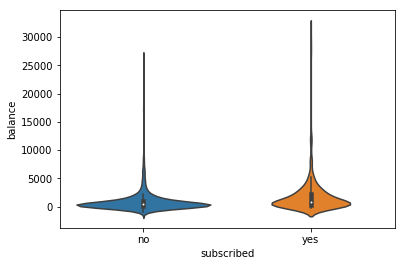

In [36]:
sns.violinplot(x='subscribed', y='balance', data=df2) 
plt.show()

Higher balances seem to subscribe more. 

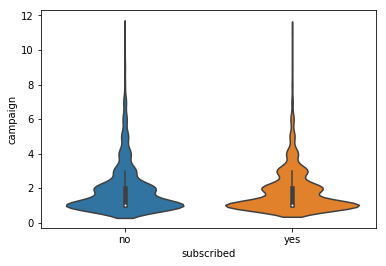

In [37]:
sns.violinplot(x='subscribed', y='campaign', data=df2) 
plt.show()

Checking campaign numbers does not seem to be as correlated.

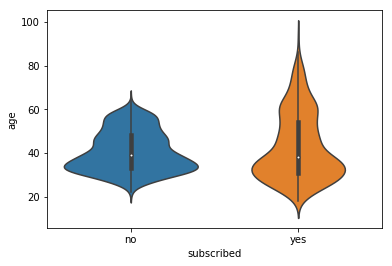

In [38]:
sns.violinplot(x='subscribed', y='age', data=df2) 
plt.show()

We see older people subscribing more than younger people.

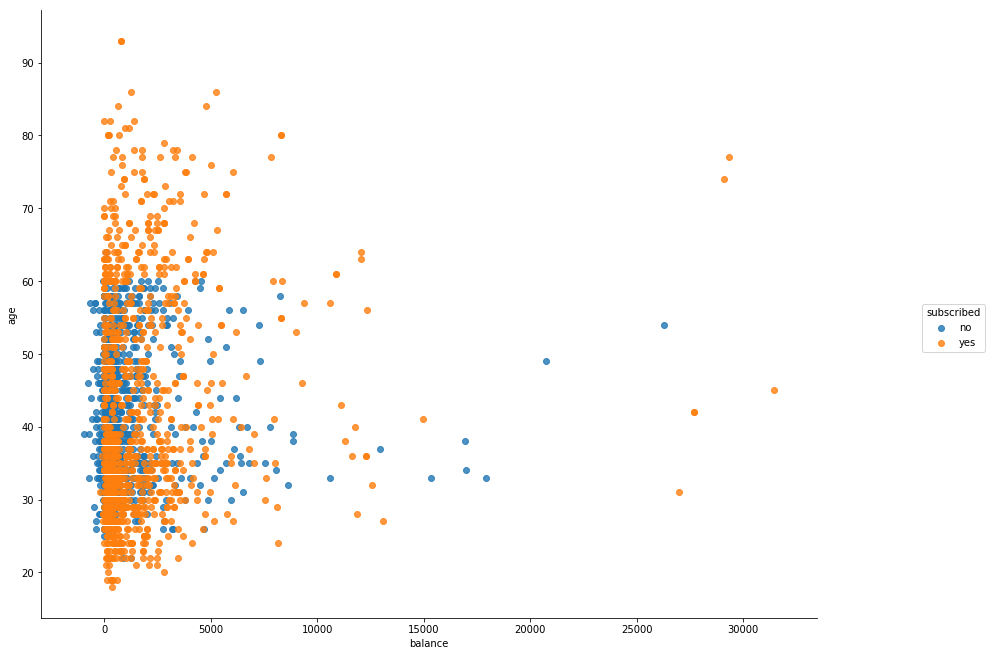

In [39]:
sns.lmplot('balance', 'age', df2, hue='subscribed', fit_reg=False)
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.show()

Everyone over 60 seems to have subscribed.
Almost everyone under 24 or so subscribed.

Everyone with a balance over 25k has subscribed bar 1, only 6 balances, so poor data for balances over 25k.

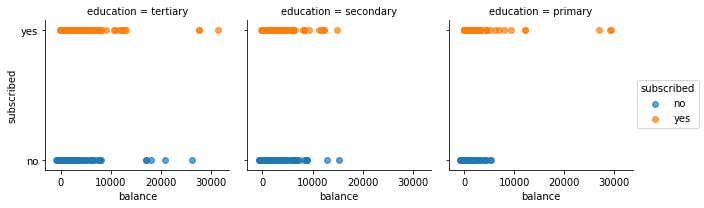

In [40]:
g = sns.FacetGrid(df2, col="education", hue="subscribed")
g.map(plt.scatter, "balance", "subscribed", alpha=.7)
g.add_legend();

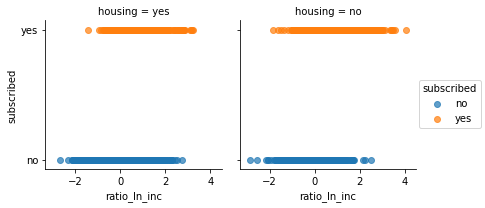

In [41]:
g = sns.FacetGrid(df2, col="housing", hue="subscribed")
g.map(plt.scatter, "ratio_ln_inc", "subscribed", alpha=.7)
g.add_legend();

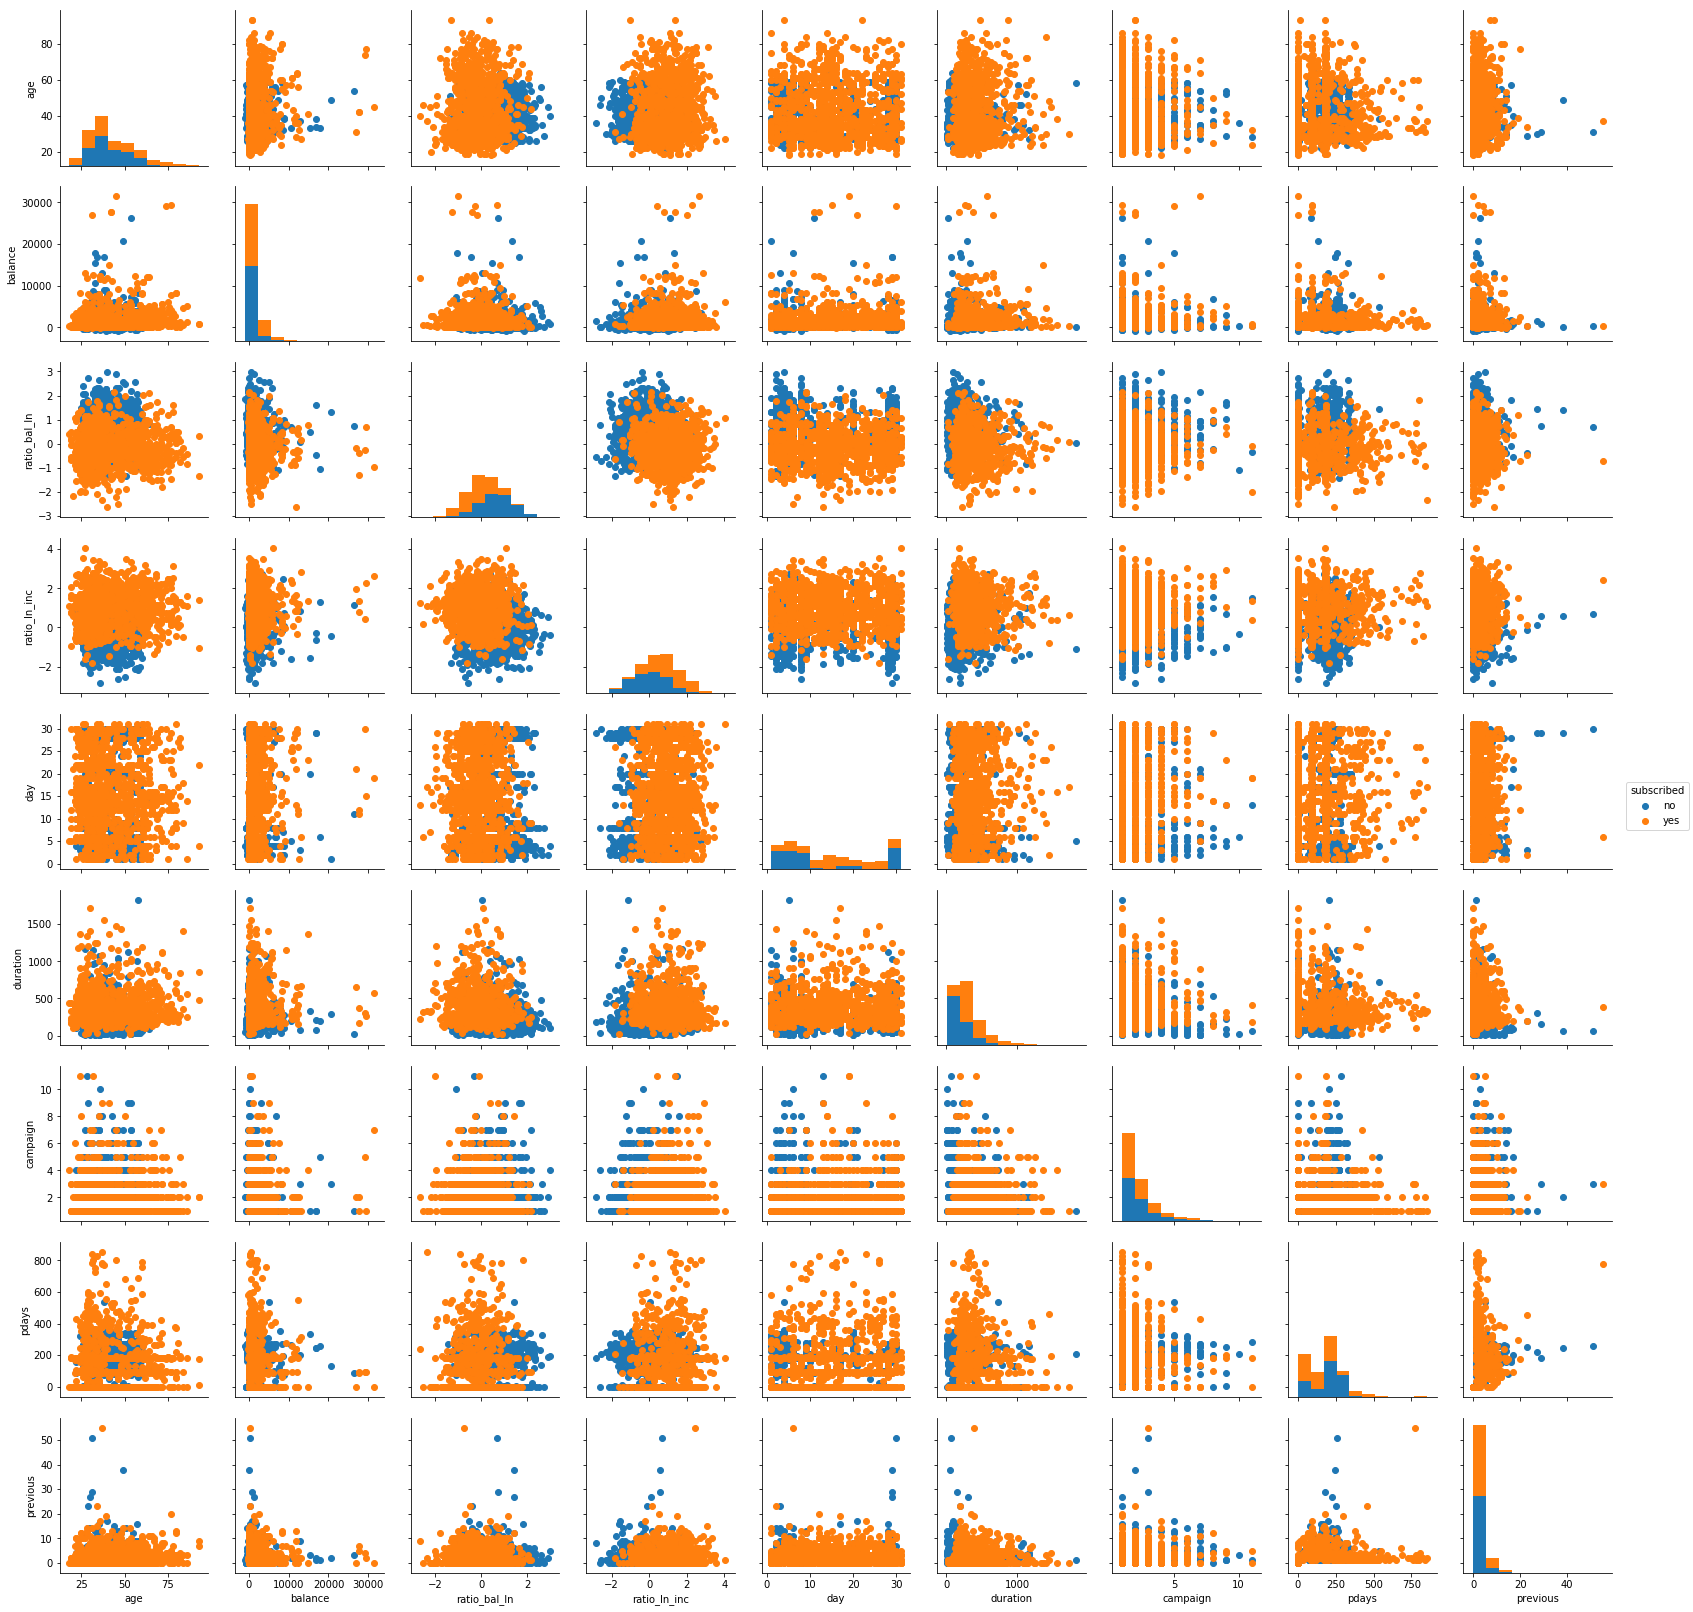

In [42]:
g = sns.PairGrid(df2, hue="subscribed")
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend();

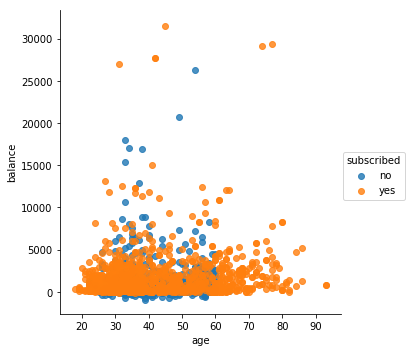

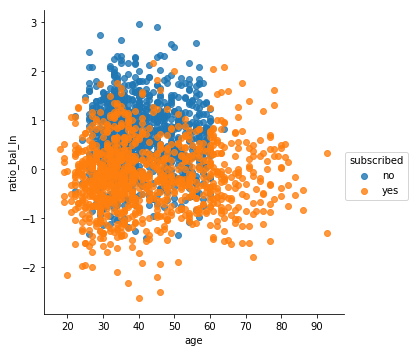

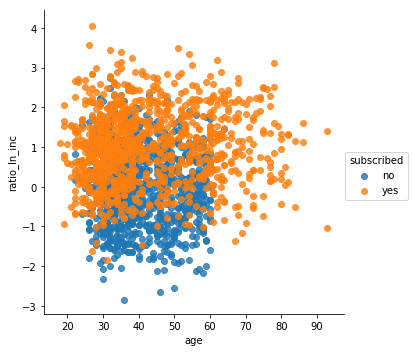

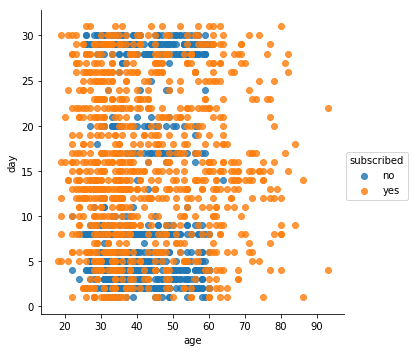

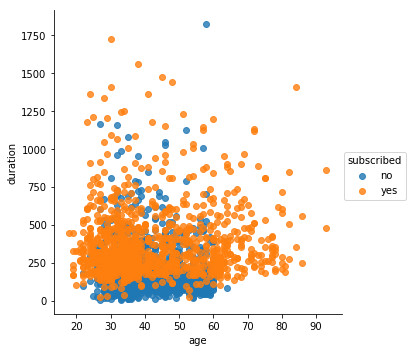

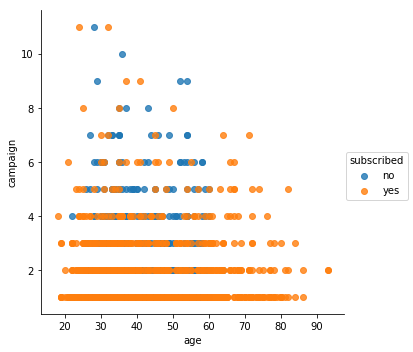

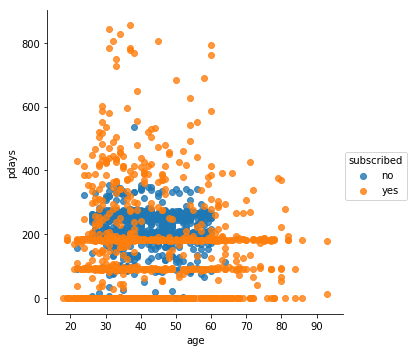

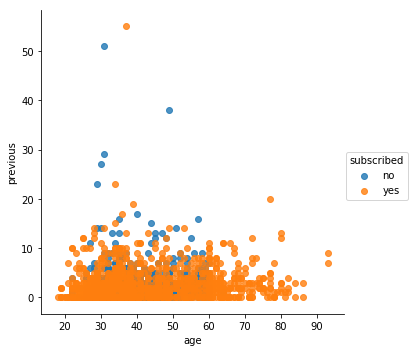

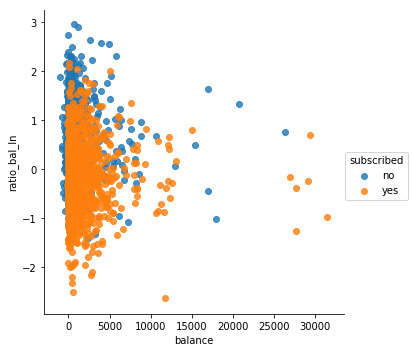

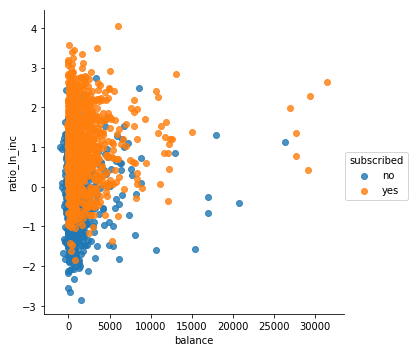

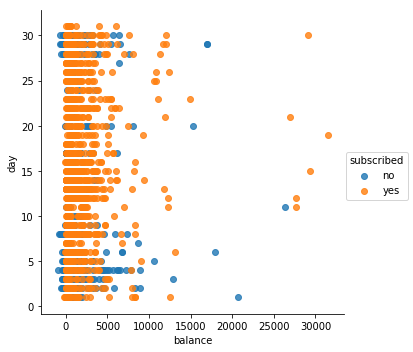

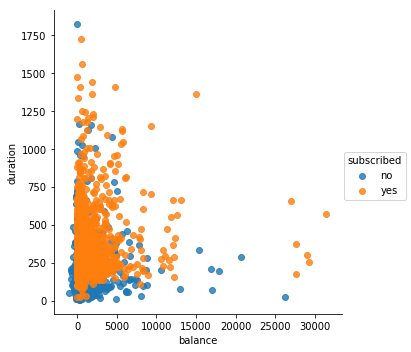

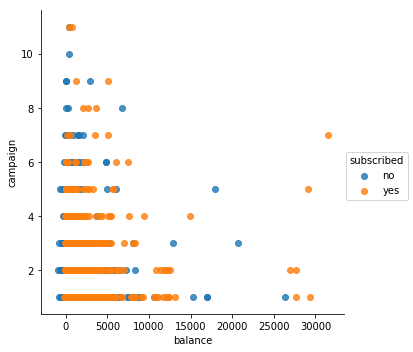

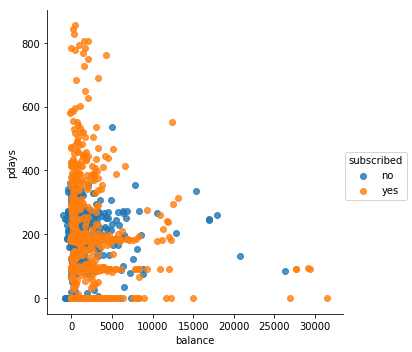

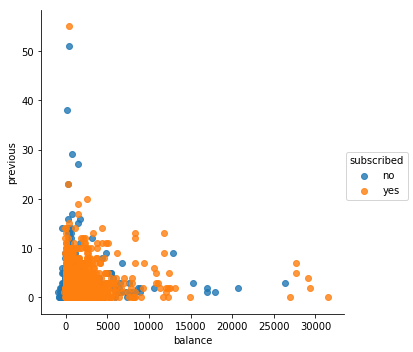

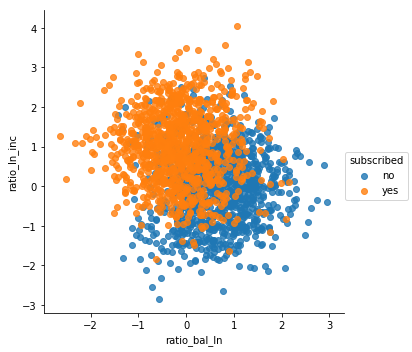

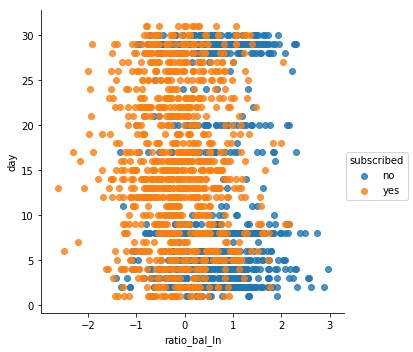

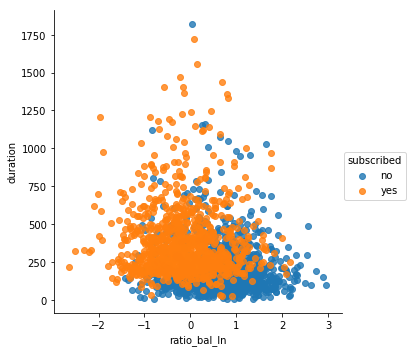

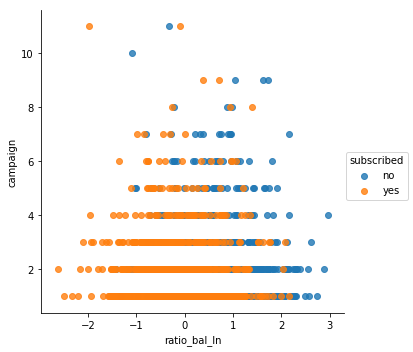

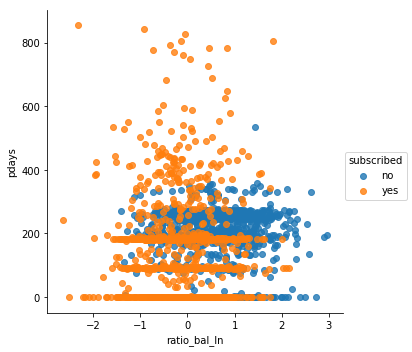

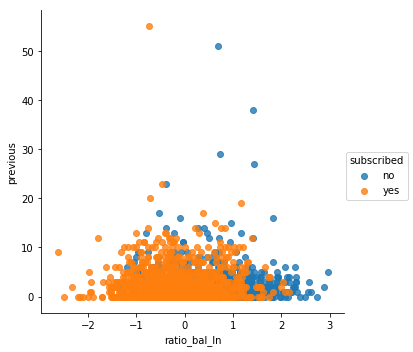

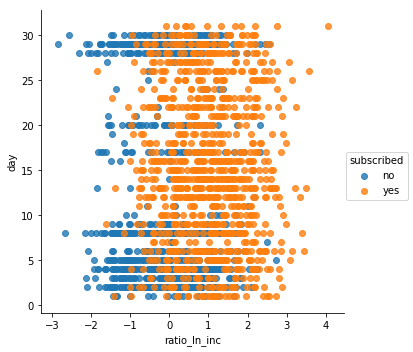

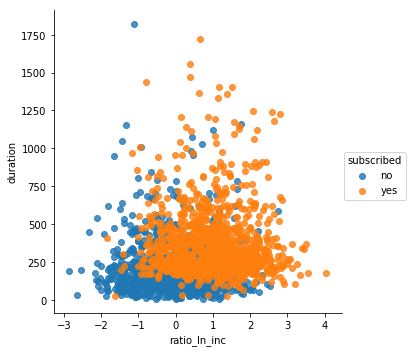

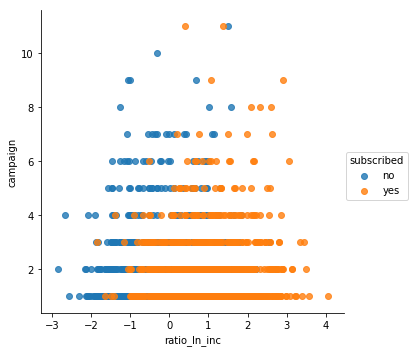

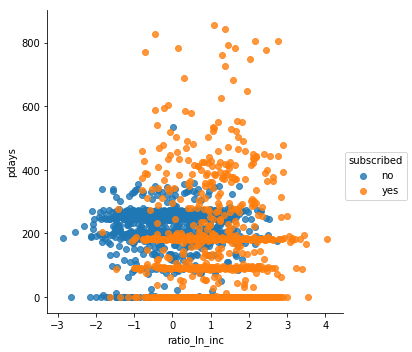

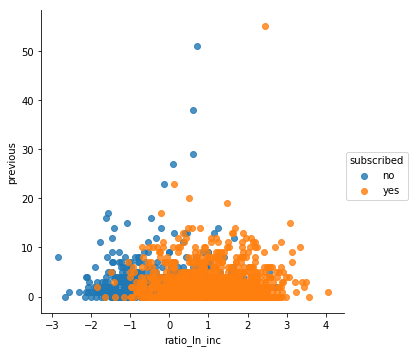

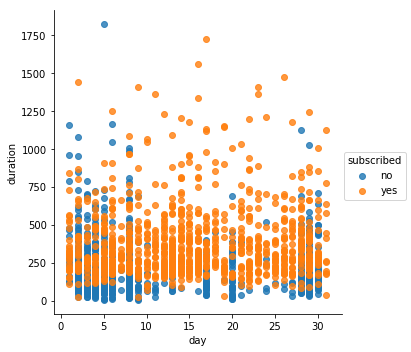

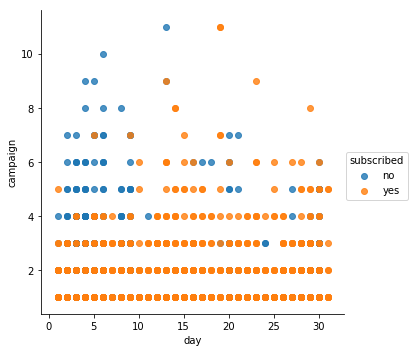

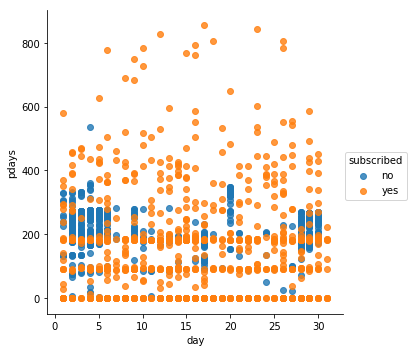

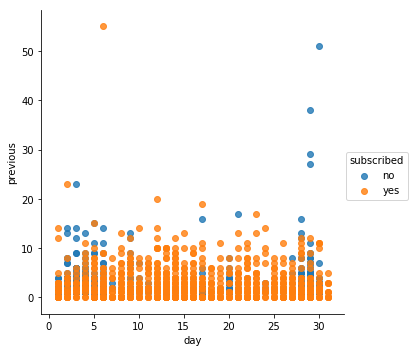

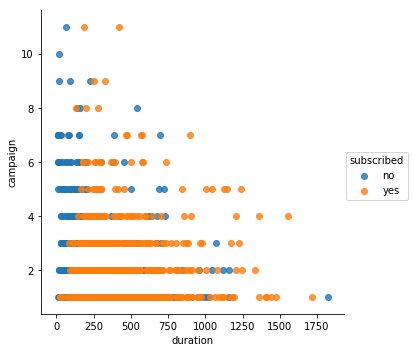

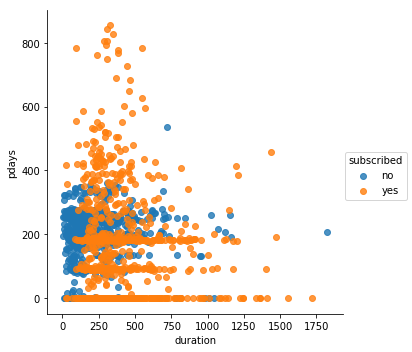

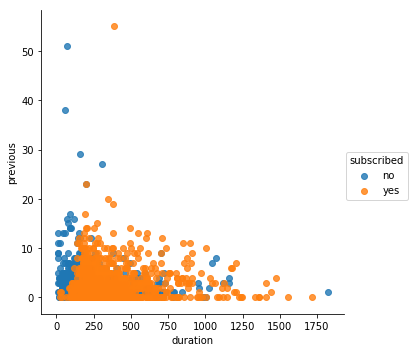

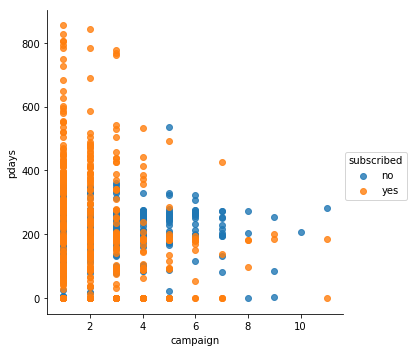

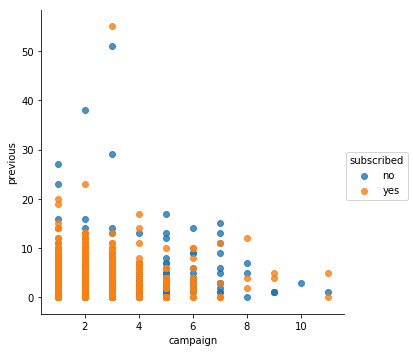

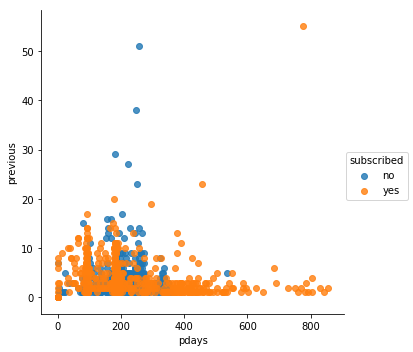

In [43]:
# all numerical values in names[]
graphs = []
i = 0
for x in names:
    for y in names: 
        if(x!=y):
            this_graph = x+y
            this_graph2 = y+x
            if this_graph in graphs:
                continue
            elif this_graph2 in graphs:
                continue
            else:
                i += 1
                graphs.append(this_graph)
                sns.lmplot(x, y, df2, hue='subscribed', fit_reg=False)
                #fig = plt.gcf()
                #fig.set_size_inches(15, 10)
                plt.show()
                

#### Review Pair Pots
A scatter plot for the vbalues, can visually show us if there is any clear separation of clusters for subscribed and unsubsrcibed for our numerical values.
There is not much separation, but the most separation is with ratio_ln_inc, ratio_bal_ln & age,
Let's zoom in.

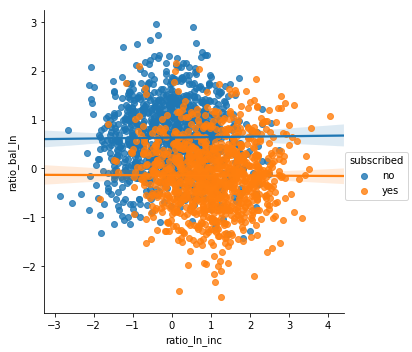

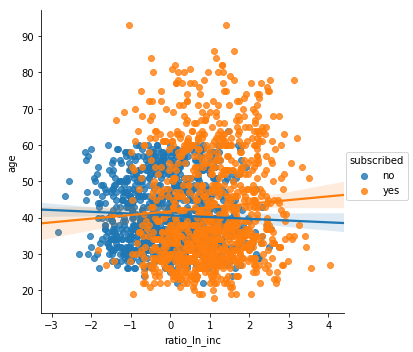

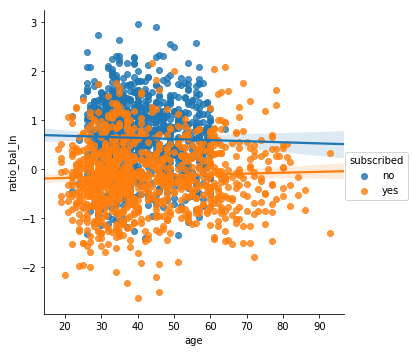

In [44]:
sns.lmplot('ratio_ln_inc', 'ratio_bal_ln', df2, hue='subscribed')
sns.lmplot('ratio_ln_inc', 'age', df2, hue='subscribed')
sns.lmplot('age', 'ratio_bal_ln', df2, hue='subscribed')


plt.show()


From all the plots of the numerical data. 

__ratio_bal_ln__ v __age__          has large but overlapping clusters

__age__          v __ratio_ln_inc__ has large but overlapping clusters

__ratio_bal_ln__ v __ratio_ln_inc__ has large but overlapping clusters

The rest are too much overlapped, so one of these three options would seem best.

### Best Pick
The largest separation from the zoomed in graphs is __ratio_bal_ln__ & __ratio_ln_inc__

## Task 3

Consider the two numerical attributes picked in Task 2 and describe (in a markdown cell) how a perceptron can be used to perform 2-class classification. Use the following terms in your description:
* Input space
* Output space
* Unknown target function
* Data set
* Hypothesis set
* Final Hypothesis
* In-sample error
* Out-of-sample error


## Task 3 Answer:
The 2 numerical attributes picked above are duration and balance to be able to preduct a target default

The Perceptron can take in our 2 chosen numerical values __ratio_bal_ln & ratio_ln_inc__ to help us predict our chosen target feature - __'subscribed'__.


For machine learning we presume there is a hidden pattern in the data which will help us with our prediction. We assume there is no mathematical solution and we have data on our chosen domain. 

In this case the data is the 2000 records of bank customers.


#### Input space


The Input space for our unknown target function f(x) is the bank records we have available. We have reduced the data we wish to learn from to be ratio_bal_ln & ratio_ln_inc numerical values for each customer.


#### Output Space
This will be the feature 'subscribed' the feature we want to predict for our bank customers, which is either 'yes' or 'no'.


#### The Unknown Target Formula
Assuming there is a pattern, we say there is a target function f(x) that will accurately predict the correct output.

We assume there is an target function f(x) which will be able to predict the correct output - 'subscribed' if we give it the input for that customer (ratio_bal_ln & ratio_ln_inc).

We have data 1000 each for subscribed 'yes' and 'no' to help us identify this function.

#### Data Set
The Data Set contains these 2000 bank customer records.

#### Hypothesis Set
To attempt to identify the target function f(x) we are providing some various candidate functions h(x) which we hope could accurately match the pattern in the data and be equivalent to the unknown target function f(x) to allow us to accurately predict the correct output. 

We may specify many possible functions, all hypothesis functions to test with - h1(x), h2(x),... hn(x)

We run the data through these Hypothesis functions to see how accurate they are. We test against the known data to see which hypothesis function is the most accurate and has the smallest error - __In-Sample Error__. 

This function would be our chosen __Final Hypothesis function g(x)__.

The expectation is that this function would be as close as possible to the target function f(x) to with in a tolerable difference when using brand new data, which the function has not been trained or checked against, this is new data which is outside of the samples seen previously and the error of the __final hypothesis function g(x)__ on this new data would be __out-of-sample Error__ should be very low - within a specified tolerance of f(x). 

f(x), the ideal function, would have zero error.

Suggestion: try PLA on this dataset before using the bank dataset

In [81]:
X, y = make_blobs(n_samples=1000, centers=2, n_features=2)
y = [yy if yy == 1 else -1 for yy in y] 

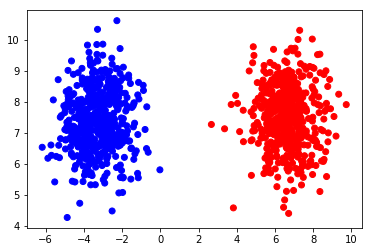

In [82]:
colors = ['red' if yy == 1 else 'blue' for yy in y] 
plt.scatter(X[:,0],X[:,1], color=colors)
plt.show()

In [74]:
def h(x,w):
    #Perceptron model: the sign of the dot product of weights and input vector determines the class allocation
    bias = np.array([1])
    return np.sign(w.T.dot(np.concatenate((bias,x))))

In [75]:
def point_on_boundary(weights, x):
    # Return the y-position on the boundary based on given x-position
    return -(weights[0]+weights[1]*x)/weights[2]

In [76]:
def decision_boundary(weights, x_min, x_max):
    # Return two points on the decision boundary
    return [pointOnBoundary(weights, x_min), pointOnBoundary(weights, x_max)]

In [77]:
def pla(training_in, training_out, weights):
    bias = np.array([1])
    iterations=0
    while True:
        errors = 0;
        for x,y in zip(training_in, training_out):
            if (h(x,weights)!=y):
                iterations+=1;
                weights = weights + y*(np.concatenate((bias,x)))
                errors+=1;
        if (errors == 0):
            break
    return weights, iterations

In [78]:
def calc_error(training_in, training_out, weights):
    # Calculate the classification error as the fraction of training samples that are misclassified
    errors=0
    for x,y in zip(training_in, training_out):
        if (h(x,weights)!=y):
            errors+=1;
    return errors/len(training_in)